In [25]:
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
import pickle
import pandas as pd
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def make_graph(history):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = "../images/Train/"
validation_dir = "../images/Validation"
test_dir = "../images/Test"
a = pd.read_csv("../train.csv")

In [3]:
train_generator = train_datagen.flow_from_dataframe(
    a,
    y_col="Id",
    x_col="Image",
    directory=train_dir,
    target_size = (299,299),
    batch_size=10,
    class_mode="categorical"
)
validation_generator = test_datagen.flow_from_dataframe(
    a,
    y_col="Id",
    x_col = "Image",
    directory=validation_dir,
    target_size = (299,299), # Xception requires images to be (299,299)
    batch_size=10,
    class_mode="categorical",
)

Found 16728 images belonging to 5005 classes.
Found 4182 images belonging to 5005 classes.


## Xception Model

In [4]:
from keras.applications import Xception
conv_base = Xception(weights='imagenet',
include_top=False,
pooling="max",
input_shape=(299, 299, 3))

In [40]:
xception_model = models.Sequential()
xception_model.add(conv_base)
xception_model.add(layers.Dense(5005, activation="softmax"))

In [6]:
conv_base.trainable = False
len(xception_model.trainable_weights)

2

In [42]:
from keras.metrics import top_k_categorical_accuracy

xception_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [8]:
xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 5005)              10255245  
Total params: 31,116,725
Trainable params: 10,255,245
Non-trainable params: 20,861,480
_________________________________________________________________


In [20]:
history = xception_model.fit_generator(
train_generator,
steps_per_epoch=1674,
epochs=10,
validation_data=validation_generator,
validation_steps=418)

Epoch 1/10
1674/1674 [==============================] - 359s 215ms/step - loss: 10.7858 - acc: 0.3454 - val_loss: 10.3938 - val_acc: 0.0748
Epoch 2/10
1674/1674 [==============================] - 357s 213ms/step - loss: 10.7719 - acc: 0.3462 - val_loss: 10.3720 - val_acc: 0.0911
Epoch 3/10
1674/1674 [==============================] - 358s 214ms/step - loss: 10.7696 - acc: 0.3461 - val_loss: 10.4942 - val_acc: 0.0858
Epoch 4/10
1674/1674 [==============================] - 358s 214ms/step - loss: 10.6811 - acc: 0.3519 - val_loss: 10.4653 - val_acc: 0.1009
Epoch 5/10
1674/1674 [==============================] - 361s 216ms/step - loss: 10.8079 - acc: 0.3439 - val_loss: 10.4309 - val_acc: 0.1028
Epoch 6/10
1674/1674 [==============================] - 359s 214ms/step - loss: 10.7717 - acc: 0.3463 - val_loss: 10.4597 - val_acc: 0.0978
Epoch 7/10
1674/1674 [==============================] - 360s 215ms/step - loss: 10.7247 - acc: 0.3492 - val_loss: 10.4684 - val_acc: 0.1062
Epoch 8/10
1674/1674

In [43]:
history2 = xception_model.fit_generator(
train_generator,
steps_per_epoch=1674,
epochs=10,
validation_data=validation_generator,
validation_steps=418)

Epoch 1/10
 421/1674 [======>.......................] - ETA: 4:01 - loss: 10.6174 - acc: 0.3344

KeyboardInterrupt: 

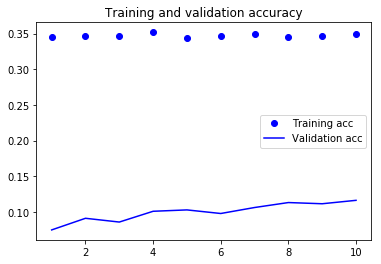

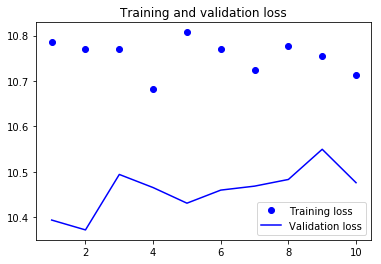

In [26]:
make_graph(history)

Very apparent overfitting should have probably added a 0.5 dropout layer before the dense layer

## Custom Depthwise-seperable Model

In [49]:
sep_model = models.Sequential()
sep_model.add(layers.SeparableConv2D(32, 3,
activation='relu',
input_shape=(299, 299, 3)))
sep_model.add(layers.SeparableConv2D(64, 3, activation='relu'))
sep_model.add(layers.MaxPooling2D(2))
sep_model.add(layers.SeparableConv2D(64, 3, activation='relu'))
sep_model.add(layers.SeparableConv2D(128, 3, activation='relu'))
sep_model.add(layers.MaxPooling2D(2))
sep_model.add(layers.SeparableConv2D(64, 3, activation='relu'))
sep_model.add(layers.SeparableConv2D(128, 3, activation='relu'))
sep_model.add(layers.GlobalAveragePooling2D())
sep_model.add(layers.Dropout(0.5))
sep_model.add(layers.Dense(8192, activation="relu"))
sep_model.add(layers.Dense(5005, activation='softmax'))
sep_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [45]:
sep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_13 (Separab (None, 297, 297, 32)      155       
_________________________________________________________________
separable_conv2d_14 (Separab (None, 295, 295, 64)      2400      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 147, 147, 64)      0         
_________________________________________________________________
separable_conv2d_15 (Separab (None, 145, 145, 64)      4736      
_________________________________________________________________
separable_conv2d_16 (Separab (None, 143, 143, 128)     8896      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
separable_conv2d_17 (Separab (None, 69, 69, 64)        9408      
__________

In [50]:
def top_5(y_true, y_pred):
    top_k_categorical_accuracy(y_true, y_pred, k=5)
sep_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [51]:
history_sep = sep_model.fit_generator(
train_generator,
steps_per_epoch=1674,
epochs=10,
validation_data=validation_generator,
validation_steps=418)

Epoch 1/10
1674/1674 [==============================] - 417s 249ms/step - loss: 6.3637 - acc: 0.3490 - val_loss: 6.5049 - val_acc: 0.3418
Epoch 2/10
1674/1674 [==============================] - 414s 247ms/step - loss: 6.0664 - acc: 0.3469 - val_loss: 6.5143 - val_acc: 0.3500
Epoch 3/10
1674/1674 [==============================] - 415s 248ms/step - loss: 6.0049 - acc: 0.3453 - val_loss: 6.7990 - val_acc: 0.3320
Epoch 4/10
1674/1674 [==============================] - 416s 249ms/step - loss: 5.9868 - acc: 0.3460 - val_loss: 6.7176 - val_acc: 0.3476
Epoch 5/10
1674/1674 [==============================] - 414s 247ms/step - loss: 5.9556 - acc: 0.3483 - val_loss: 6.8269 - val_acc: 0.3440
Epoch 6/10
1674/1674 [==============================] - 414s 247ms/step - loss: 5.9670 - acc: 0.3456 - val_loss: 6.8480 - val_acc: 0.3452
Epoch 7/10
1674/1674 [==============================] - 414s 247ms/step - loss: 5.9359 - acc: 0.3482 - val_loss: 6.9735 - val_acc: 0.3428
Epoch 8/10
1674/1674 [============

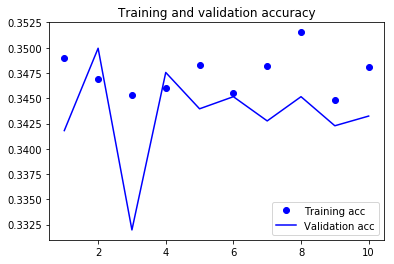

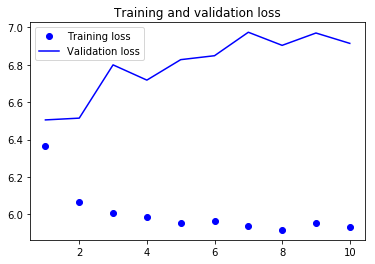

In [52]:
make_graph(history_sep)

In [ ]:

train_generator_grey = train_datagen.flow_from_dataframe(
    a,
    y_col="Id",
    x_col="Image",
    directory=train_dir,
    target_size = (299,299),
    batch_size=10,
    colormode="greyscale"
    class_mode="categorical"
)
validation_generator_grey = test_datagen.flow_from_dataframe(
    a,
    y_col="Id",
    x_col = "Image",
    directory=validation_dir,
    target_size = (299,299), # Xception requires images to be (299,299)
    batch_size=10,
    colormode="greyscale",
    class_mode="categorical",
)